### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls, freeze_botom
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


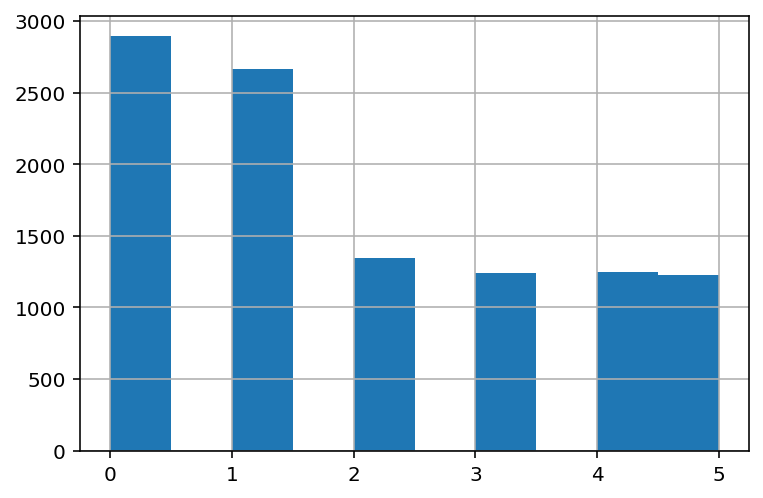

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

16-05-2020-19-07


In [10]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type)
}

### Train Eval Loop

In [13]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, scheduler, sch_is_epoch_type,
                    num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0])
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds),
                          global_step=step)
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                preds_to_tb(outputs, inputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(tag=f"lr Interim {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
            writer.add_scalar(tag=f"lr Classifier {tb_tag}:", scalar_value=optimizer.param_groups[1]["lr"], global_step=train_global_step)
            
        else:
            writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    writer.close()

### Prepare CV - strategy

In [14]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [15]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [18]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1 loss: ls_soft_ce


In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug="heavy"), debug=False) # NOTE! it is predefined 36-tiles images
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=30)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Training Loss: 1.4133	Validation Loss: 1.3378
Counter train preds: Counter({0: 3171, 1: 2178, 5: 974, 3: 583, 4: 559, 2: 497})	Counter val preds: Counter({1: 964, 0: 951, 2: 237, 4: 185, 3: 164, 5: 153})
Epoch train QWK: 0.590	val QWK: 0.636
  Epoch 0 - Save Best Loss: 1.3378 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
  Epoch 0 - Save Best QWK: 0.6357 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
Epoch 1/29


100%|██████████| 166/166 [00:14<00:00, 11.12it/s]


Training Loss: 1.3243	Validation Loss: 1.2604
Counter train preds: Counter({0: 3068, 1: 2105, 5: 931, 3: 659, 4: 614, 2: 585})	Counter val preds: Counter({0: 1165, 5: 408, 1: 357, 2: 345, 3: 195, 4: 184})
Epoch train QWK: 0.663	val QWK: 0.723
  Epoch 1 - Save Best Loss: 1.2604 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
  Epoch 1 - Save Best QWK: 0.7233 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
Epoch 2/29


100%|██████████| 166/166 [00:14<00:00, 11.36it/s]


Training Loss: 1.2768	Validation Loss: 1.2445
Counter train preds: Counter({0: 2990, 1: 2062, 5: 903, 4: 712, 2: 654, 3: 641})	Counter val preds: Counter({0: 988, 1: 664, 5: 486, 3: 310, 4: 129, 2: 77})
Epoch train QWK: 0.694	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2445 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
  Epoch 2 - Save Best QWK: 0.7243 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
Epoch 3/29


100%|██████████| 166/166 [00:16<00:00, 10.25it/s]


Training Loss: 1.2524	Validation Loss: 1.2349
Counter train preds: Counter({0: 2952, 1: 2107, 5: 934, 3: 729, 4: 638, 2: 602})	Counter val preds: Counter({1: 836, 0: 797, 5: 349, 3: 253, 4: 229, 2: 190})
Epoch train QWK: 0.708	val QWK: 0.764
  Epoch 3 - Save Best Loss: 1.2349 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
  Epoch 3 - Save Best QWK: 0.7642 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
Epoch 4/29


100%|██████████| 166/166 [00:15<00:00, 10.78it/s]

Training Loss: 1.2235	Validation Loss: 1.2475
Counter train preds: Counter({0: 2866, 1: 2110, 5: 923, 4: 713, 3: 677, 2: 673})	Counter val preds: Counter({0: 1068, 1: 627, 4: 370, 3: 248, 5: 245, 2: 96})
Epoch train QWK: 0.727	val QWK: 0.739
Epoch 5/29



100%|██████████| 166/166 [00:14<00:00, 11.65it/s]


Training Loss: 1.2193	Validation Loss: 1.2217
Counter train preds: Counter({0: 2865, 1: 2125, 5: 921, 3: 716, 4: 712, 2: 623})	Counter val preds: Counter({1: 887, 0: 850, 3: 307, 4: 232, 2: 218, 5: 160})
Epoch train QWK: 0.735	val QWK: 0.727
  Epoch 5 - Save Best Loss: 1.2217 Model
Confusion matrix, without normalization
[[616  87   2   3   9   6]
 [134 488  24  17   3   0]
 [ 20 209  74  22   7   3]
 [ 28  46  73 130  19  15]
 [ 26  48  24  68 123  24]
 [ 26   9  21  67  71 112]]
Epoch 6/29


100%|██████████| 166/166 [00:15<00:00, 10.50it/s]

Training Loss: 1.1916	Validation Loss: 1.2237
Counter train preds: Counter({0: 2830, 1: 2097, 5: 913, 3: 743, 4: 722, 2: 657})	Counter val preds: Counter({1: 895, 0: 872, 3: 277, 5: 261, 2: 209, 4: 140})
Epoch train QWK: 0.751	val QWK: 0.734
Epoch 7/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]

Training Loss: 1.1780	Validation Loss: 1.2794
Counter train preds: Counter({0: 2802, 1: 2125, 5: 923, 4: 728, 3: 724, 2: 660})	Counter val preds: Counter({0: 1195, 1: 461, 5: 338, 4: 308, 2: 241, 3: 111})
Epoch train QWK: 0.760	val QWK: 0.724
Epoch 8/29



  6%|▋         | 32/498 [00:10<02:30,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.45it/s]

Training Loss: 1.1537	Validation Loss: 1.2326
Counter train preds: Counter({0: 2766, 1: 2073, 5: 922, 4: 753, 2: 727, 3: 721})	Counter val preds: Counter({0: 970, 1: 600, 4: 415, 5: 261, 2: 222, 3: 186})
Epoch train QWK: 0.775	val QWK: 0.742
Epoch 9/29



100%|██████████| 166/166 [00:17<00:00,  9.62it/s]

Epoch    10: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 1.1571	Validation Loss: 1.2449
Counter train preds: Counter({0: 2746, 1: 2079, 5: 912, 3: 791, 4: 745, 2: 689})	Counter val preds: Counter({1: 1001, 0: 814, 5: 246, 2: 221, 3: 219, 4: 153})
Epoch train QWK: 0.767	val QWK: 0.717
Epoch 10/29



100%|██████████| 166/166 [00:14<00:00, 11.80it/s]


Training Loss: 1.0783	Validation Loss: 1.1852
Counter train preds: Counter({0: 2674, 1: 2077, 5: 928, 4: 786, 3: 769, 2: 728})	Counter val preds: Counter({0: 872, 1: 686, 5: 383, 4: 269, 3: 233, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.762
  Epoch 10 - Save Best Loss: 1.1852 Model
Confusion matrix, without normalization
[[633  62   2   5  11  10]
 [139 424  55  26  22   0]
 [ 22 136  95  43  22  17]
 [ 27  31  33 110  43  67]
 [ 27  27  19  35 128  77]
 [ 24   6   7  14  43 212]]
Epoch 11/29


100%|██████████| 166/166 [00:14<00:00, 11.79it/s]


Training Loss: 1.0550	Validation Loss: 1.2170
Counter train preds: Counter({0: 2645, 1: 2025, 5: 936, 4: 803, 2: 797, 3: 756})	Counter val preds: Counter({0: 968, 1: 566, 5: 453, 2: 265, 3: 220, 4: 182})
Epoch train QWK: 0.819	val QWK: 0.766
  Epoch 11 - Save Best QWK: 0.7663 Model
Confusion matrix, without normalization
[[662  45   2   4   3   7]
 [181 366  84  13  15   7]
 [ 35  99 121  45  16  19]
 [ 32  23  34 109  27  86]
 [ 31  29  15  38  97 103]
 [ 27   4   9  11  24 231]]
Epoch 12/29


  8%|▊         | 42/498 [00:13<02:11,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:16<00:00, 10.31it/s]

Training Loss: 1.0295	Validation Loss: 1.2241
Counter train preds: Counter({0: 2631, 1: 2021, 5: 895, 2: 815, 4: 801, 3: 799})	Counter val preds: Counter({0: 921, 1: 797, 5: 258, 3: 255, 4: 222, 2: 201})
Epoch train QWK: 0.821	val QWK: 0.754
Epoch 13/29



100%|██████████| 166/166 [00:14<00:00, 11.82it/s]

Training Loss: 1.0086	Validation Loss: 1.2355
Counter train preds: Counter({0: 2553, 1: 2047, 5: 940, 2: 815, 4: 813, 3: 794})	Counter val preds: Counter({0: 995, 1: 581, 2: 387, 5: 293, 3: 214, 4: 184})
Epoch train QWK: 0.843	val QWK: 0.752
Epoch 14/29



100%|██████████| 166/166 [00:14<00:00, 11.78it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.9891	Validation Loss: 1.2672
Counter train preds: Counter({0: 2550, 1: 2031, 5: 919, 3: 833, 2: 832, 4: 797})	Counter val preds: Counter({0: 854, 1: 731, 4: 385, 5: 364, 2: 190, 3: 130})
Epoch train QWK: 0.844	val QWK: 0.763
Epoch 15/29



100%|██████████| 166/166 [00:15<00:00, 10.71it/s]


Training Loss: 0.9256	Validation Loss: 1.2372
Counter train preds: Counter({0: 2517, 1: 2001, 5: 894, 2: 886, 4: 846, 3: 818})	Counter val preds: Counter({0: 888, 1: 612, 3: 362, 2: 285, 5: 260, 4: 247})
Epoch train QWK: 0.868	val QWK: 0.767
  Epoch 15 - Save Best QWK: 0.7666 Model
Confusion matrix, without normalization
[[631  70   3  13   2   4]
 [146 389  85  35   9   2]
 [ 27  98 137  56  13   4]
 [ 30  21  39 151  38  32]
 [ 30  21  15  67 135  45]
 [ 24  13   6  40  50 173]]
Epoch 16/29


 13%|█▎        | 67/498 [00:20<02:05,  3.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.9068	Validation Loss: 1.2451
Counter train preds: Counter({0: 2501, 1: 1981, 5: 924, 2: 901, 3: 831, 4: 824})	Counter val preds: Counter({0: 868, 1: 740, 2: 287, 3: 280, 5: 247, 4: 232})
Epoch train QWK: 0.876	val QWK: 0.754
Epoch 17/29



100%|██████████| 166/166 [00:15<00:00, 10.44it/s]

Training Loss: 0.8845	Validation Loss: 1.2586
Counter train preds: Counter({0: 2483, 1: 1987, 5: 913, 2: 888, 4: 866, 3: 825})	Counter val preds: Counter({0: 844, 1: 579, 5: 348, 3: 298, 2: 296, 4: 289})
Epoch train QWK: 0.881	val QWK: 0.764
Epoch 18/29



100%|██████████| 166/166 [00:15<00:00, 10.56it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.8628	Validation Loss: 1.2978
Counter train preds: Counter({0: 2465, 1: 1989, 5: 915, 2: 894, 4: 864, 3: 835})	Counter val preds: Counter({0: 817, 1: 634, 2: 407, 5: 305, 3: 289, 4: 202})
Epoch train QWK: 0.893	val QWK: 0.763
Epoch 19/29



100%|██████████| 166/166 [00:14<00:00, 11.44it/s]


Training Loss: 0.8329	Validation Loss: 1.2674
Counter train preds: Counter({0: 2413, 1: 2033, 2: 935, 5: 906, 4: 867, 3: 808})	Counter val preds: Counter({0: 843, 1: 638, 2: 380, 5: 292, 4: 253, 3: 248})
Epoch train QWK: 0.897	val QWK: 0.771
  Epoch 19 - Save Best QWK: 0.7708 Model
Confusion matrix, without normalization
[[617  87   7   4   3   5]
 [127 398 113  17   7   4]
 [ 23  95 157  44  13   3]
 [ 25  24  64 112  44  42]
 [ 24  25  26  42 135  61]
 [ 27   9  13  29  51 177]]
Epoch 20/29


 18%|█▊        | 90/498 [00:28<02:00,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


Training Loss: 0.8309	Validation Loss: 1.2587
Counter train preds: Counter({0: 2444, 1: 1971, 2: 946, 5: 906, 4: 855, 3: 840})	Counter val preds: Counter({0: 905, 1: 645, 5: 348, 2: 288, 4: 254, 3: 214})
Epoch train QWK: 0.895	val QWK: 0.772
  Epoch 20 - Save Best QWK: 0.7721 Model
Confusion matrix, without normalization
[[638  67   7   5   2   4]
 [156 399  82  11  13   5]
 [ 27 112 129  38  19  10]
 [ 30  31  46 104  49  51]
 [ 29  25  16  32 137  74]
 [ 25  11   8  24  34 204]]
Epoch 21/29


100%|██████████| 166/166 [00:16<00:00, 10.07it/s]

Training Loss: 0.8118	Validation Loss: 1.2990
Counter train preds: Counter({0: 2425, 1: 1992, 2: 920, 5: 913, 4: 863, 3: 849})	Counter val preds: Counter({0: 863, 1: 560, 2: 397, 4: 287, 3: 274, 5: 273})
Epoch train QWK: 0.904	val QWK: 0.766
Epoch 22/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]


Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.8106	Validation Loss: 1.2867
Counter train preds: Counter({0: 2392, 1: 2022, 2: 934, 5: 910, 4: 880, 3: 824})	Counter val preds: Counter({0: 844, 1: 588, 2: 388, 5: 310, 4: 274, 3: 250})
Epoch train QWK: 0.898	val QWK: 0.773
  Epoch 22 - Save Best QWK: 0.7731 Model
Confusion matrix, without normalization
[[610  87  10   6   5   5]
 [139 365 121  26  10   5]
 [ 24  80 164  46  17   4]
 [ 21  24  62 114  45  45]
 [ 25  24  18  39 147  60]
 [ 25   8  13  19  50 191]]
Epoch 23/29


100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Training Loss: 0.7927	Validation Loss: 1.2908
Counter train preds: Counter({0: 2397, 1: 1984, 5: 944, 2: 931, 3: 874, 4: 832})	Counter val preds: Counter({0: 840, 1: 644, 2: 377, 5: 274, 3: 270, 4: 249})
Epoch train QWK: 0.906	val QWK: 0.766
Epoch 24/29



 41%|████      | 204/498 [01:01<01:24,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]

Training Loss: 0.7887	Validation Loss: 1.2833
Counter train preds: Counter({0: 2403, 1: 1975, 2: 947, 5: 891, 4: 890, 3: 856})	Counter val preds: Counter({0: 863, 1: 672, 2: 376, 4: 297, 5: 265, 3: 181})
Epoch train QWK: 0.906	val QWK: 0.760
Epoch 25/29



100%|██████████| 166/166 [00:14<00:00, 11.74it/s]

Training Loss: 0.7820	Validation Loss: 1.2766
Counter train preds: Counter({0: 2399, 1: 1977, 2: 951, 5: 904, 4: 874, 3: 857})	Counter val preds: Counter({0: 859, 1: 629, 2: 323, 3: 313, 5: 275, 4: 255})
Epoch train QWK: 0.907	val QWK: 0.765
Epoch 26/29



100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.7875	Validation Loss: 1.2824
Counter train preds: Counter({0: 2443, 1: 1964, 2: 935, 5: 905, 3: 877, 4: 838})	Counter val preds: Counter({0: 838, 1: 655, 2: 371, 5: 292, 3: 290, 4: 208})
Epoch train QWK: 0.906	val QWK: 0.759
Epoch 27/29



100%|██████████| 166/166 [00:15<00:00, 10.60it/s]

Training Loss: 0.7610	Validation Loss: 1.3068
Counter train preds: Counter({0: 2411, 1: 1954, 2: 952, 5: 937, 4: 861, 3: 847})	Counter val preds: Counter({0: 886, 1: 561, 2: 348, 3: 338, 5: 284, 4: 237})
Epoch train QWK: 0.917	val QWK: 0.759
Epoch 28/29



 51%|█████▏    | 256/498 [01:17<01:09,  3.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.7612	Validation Loss: 1.2853
Counter train preds: Counter({0: 2396, 1: 1962, 2: 947, 5: 916, 4: 880, 3: 861})	Counter val preds: Counter({0: 855, 1: 665, 2: 342, 5: 313, 3: 248, 4: 231})
Epoch train QWK: 0.917	val QWK: 0.764
Epoch 29/29



100%|██████████| 166/166 [00:14<00:00, 11.73it/s]

Training Loss: 0.7683	Validation Loss: 1.2812
Counter train preds: Counter({0: 2405, 1: 1990, 2: 934, 5: 886, 4: 880, 3: 867})	Counter val preds: Counter({0: 888, 1: 609, 2: 364, 5: 295, 3: 262, 4: 236})
Epoch train QWK: 0.914	val QWK: 0.762


### Experiment Run

In [17]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 768
 img_width: 768
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 144
 tile_sz: 64
 batch_size: 8
 use_lazy: True
 aug_type: light
 finetune: False
 model_cls: deep
 schedule_type: cawr
 cawr_T: 1
 cawr_Tmult: 2
 loss: ls_soft_ce
 optim: sgd
 lr: 0.0015625
 rlopp: 3
 epoch: 50
 n_fold: 4
 use_amp: True



In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [18]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp, verbose=True), 
                SCHEDULERS[schedule_type][1])
    if schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    if schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])

In [19]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.use_lazy:
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
else:
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=6)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/49


  0%|          | 1/996 [00:00<11:25,  1.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  0%|          | 2/996 [00:00<09:25,  1.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  1%|          | 5/996 [00:02<07:44,  2.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 332/332 [02:02<00:00,  2.72it/s]


Training Loss: 1.4987	Validation Loss: 1.3563
Counter train preds: Counter({0: 3020, 1: 2182, 5: 961, 3: 630, 4: 605, 2: 564})	Counter val preds: Counter({0: 1092, 5: 649, 1: 624, 2: 139, 4: 107, 3: 43})
Epoch train QWK: 0.523	val QWK: 0.663
  Epoch 0 - Save Best Loss: 1.3563 Model
Confusion matrix, without normalization
[[642  44   2   1  14  20]
 [227 381  30   6   7  15]
 [ 62 116  79  11  15  52]
 [ 52  41  21  18  20 159]
 [ 61  34   6   5  39 168]
 [ 48   8   1   2  12 235]]
  Epoch 0 - Save Best QWK: 0.6634 Model
Confusion matrix, without normalization
[[642  44   2   1  14  20]
 [227 381  30   6   7  15]
 [ 62 116  79  11  15  52]
 [ 52  41  21  18  20 159]
 [ 61  34   6   5  39 168]
 [ 48   8   1   2  12 235]]
Epoch 1/49


 64%|██████▎   | 633/996 [03:21<01:55,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 332/332 [02:05<00:00,  2.64it/s]


Training Loss: 1.4497	Validation Loss: 1.2662
Counter train preds: Counter({0: 2765, 1: 2239, 5: 952, 4: 705, 2: 660, 3: 641})	Counter val preds: Counter({0: 929, 1: 874, 4: 337, 5: 267, 3: 184, 2: 63})
Epoch train QWK: 0.594	val QWK: 0.709
  Epoch 1 - Save Best Loss: 1.2662 Model
Confusion matrix, without normalization
[[616  83   0   7   9   8]
 [153 482   9   5  15   2]
 [ 42 195  34  30  29   5]
 [ 37  61  12  81  88  32]
 [ 43  44   5  31 121  69]
 [ 38   9   3  30  75 151]]
  Epoch 1 - Save Best QWK: 0.7086 Model
Confusion matrix, without normalization
[[616  83   0   7   9   8]
 [153 482   9   5  15   2]
 [ 42 195  34  30  29   5]
 [ 37  61  12  81  88  32]
 [ 43  44   5  31 121  69]
 [ 38   9   3  30  75 151]]
Epoch 2/49


100%|██████████| 332/332 [02:05<00:00,  2.64it/s]


Training Loss: 1.3020	Validation Loss: 1.2263
Counter train preds: Counter({0: 2741, 1: 2233, 5: 909, 4: 736, 3: 728, 2: 615})	Counter val preds: Counter({0: 972, 1: 609, 5: 462, 3: 230, 4: 199, 2: 182})
Epoch train QWK: 0.671	val QWK: 0.737
  Epoch 2 - Save Best Loss: 1.2263 Model
Confusion matrix, without normalization
[[645  56   2   2  11   7]
 [177 383  62  24  14   6]
 [ 43 103  93  58  14  24]
 [ 38  33  14  96  36  94]
 [ 35  25   9  32  92 120]
 [ 34   9   2  18  32 211]]
  Epoch 2 - Save Best QWK: 0.7373 Model
Confusion matrix, without normalization
[[645  56   2   2  11   7]
 [177 383  62  24  14   6]
 [ 43 103  93  58  14  24]
 [ 38  33  14  96  36  94]
 [ 35  25   9  32  92 120]
 [ 34   9   2  18  32 211]]
Epoch 3/49


 85%|████████▍ | 843/996 [04:29<00:47,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]


Training Loss: 1.3905	Validation Loss: 1.2767
Counter train preds: Counter({0: 2705, 1: 2199, 5: 892, 4: 765, 3: 709, 2: 692})	Counter val preds: Counter({1: 998, 0: 703, 5: 478, 3: 221, 4: 173, 2: 81})
Epoch train QWK: 0.635	val QWK: 0.744
  Epoch 3 - Save Best QWK: 0.7439 Model
Confusion matrix, without normalization
[[529 167   2   0   3  22]
 [104 507  20  15   8  12]
 [ 20 194  34  53  13  21]
 [ 17  61  19 101  33  80]
 [ 17  46   4  33  88 125]
 [ 16  23   2  19  28 218]]
Epoch 4/49


100%|██████████| 332/332 [02:05<00:00,  2.65it/s]


Training Loss: 1.3209	Validation Loss: 1.2148
Counter train preds: Counter({0: 2686, 1: 2166, 5: 961, 4: 763, 3: 699, 2: 687})	Counter val preds: Counter({0: 774, 1: 741, 5: 342, 4: 320, 2: 243, 3: 234})
Epoch train QWK: 0.684	val QWK: 0.756
  Epoch 4 - Save Best Loss: 1.2148 Model
Confusion matrix, without normalization
[[577 102   3  10  23   8]
 [129 434  63  16  24   0]
 [ 19 110 120  49  19  18]
 [ 21  39  38 102  56  55]
 [ 11  37  14  34 147  70]
 [ 17  19   5  23  51 191]]
  Epoch 4 - Save Best QWK: 0.7559 Model
Confusion matrix, without normalization
[[577 102   3  10  23   8]
 [129 434  63  16  24   0]
 [ 19 110 120  49  19  18]
 [ 21  39  38 102  56  55]
 [ 11  37  14  34 147  70]
 [ 17  19   5  23  51 191]]
Epoch 5/49


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


Training Loss: 1.2321	Validation Loss: 1.1582
Counter train preds: Counter({0: 2647, 1: 2166, 5: 914, 4: 757, 2: 740, 3: 738})	Counter val preds: Counter({0: 870, 1: 735, 5: 417, 4: 249, 2: 231, 3: 152})
Epoch train QWK: 0.728	val QWK: 0.770
  Epoch 5 - Save Best Loss: 1.1582 Model
Confusion matrix, without normalization
[[641  64   2   1   8   7]
 [118 473  53   5   9   8]
 [ 23 130 118  34   8  22]
 [ 33  37  36  68  59  78]
 [ 28  26  18  29 122  90]
 [ 27   5   4  15  43 212]]
  Epoch 5 - Save Best QWK: 0.7696 Model
Confusion matrix, without normalization
[[641  64   2   1   8   7]
 [118 473  53   5   9   8]
 [ 23 130 118  34   8  22]
 [ 33  37  36  68  59  78]
 [ 28  26  18  29 122  90]
 [ 27   5   4  15  43 212]]
Epoch 6/49


100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


Training Loss: 1.1745	Validation Loss: 1.1495
Counter train preds: Counter({0: 2572, 1: 2206, 5: 900, 3: 805, 4: 752, 2: 727})	Counter val preds: Counter({0: 830, 1: 780, 5: 423, 2: 230, 4: 198, 3: 193})
Epoch train QWK: 0.753	val QWK: 0.769
  Epoch 6 - Save Best Loss: 1.1495 Model
Confusion matrix, without normalization
[[624  79   3   1  11   5]
 [107 487  50   7   8   7]
 [ 17 136 118  36   8  20]
 [ 33  36  37  93  36  76]
 [ 26  31  17  35 103 101]
 [ 23  11   5  21  32 214]]
Epoch 7/49


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 1.3250	Validation Loss: 1.2258
Counter train preds: Counter({0: 2647, 1: 2161, 5: 932, 3: 760, 4: 750, 2: 712})	Counter val preds: Counter({0: 918, 1: 843, 5: 389, 3: 249, 4: 216, 2: 39})
Epoch train QWK: 0.688	val QWK: 0.742
Epoch 8/49



100%|██████████| 332/332 [02:06<00:00,  2.63it/s]

Training Loss: 1.2890	Validation Loss: 1.2803
Counter train preds: Counter({0: 2551, 1: 2180, 5: 894, 4: 799, 2: 776, 3: 762})	Counter val preds: Counter({0: 844, 1: 684, 5: 539, 4: 239, 3: 215, 2: 133})
Epoch train QWK: 0.707	val QWK: 0.751
Epoch 9/49



 91%|█████████ | 907/996 [05:13<00:30,  2.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.2485	Validation Loss: 1.1913
Counter train preds: Counter({0: 2604, 1: 2147, 5: 918, 4: 775, 2: 774, 3: 744})	Counter val preds: Counter({0: 906, 1: 666, 3: 385, 5: 356, 4: 210, 2: 131})
Epoch train QWK: 0.727	val QWK: 0.767
Epoch 10/49



 68%|██████▊   | 676/996 [03:32<01:38,  3.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


Training Loss: 1.1979	Validation Loss: 1.2052
Counter train preds: Counter({0: 2538, 1: 2152, 5: 889, 3: 804, 4: 798, 2: 781})	Counter val preds: Counter({0: 846, 1: 758, 5: 557, 4: 201, 3: 172, 2: 120})
Epoch train QWK: 0.748	val QWK: 0.774
  Epoch 10 - Save Best QWK: 0.7745 Model
Confusion matrix, without normalization
[[638  60   1   2   7  15]
 [122 475  28  18  10  13]
 [ 21 154  64  48  18  30]
 [ 27  36  19  62  55 112]
 [ 19  23   8  28  91 144]
 [ 19  10   0  14  20 243]]
Epoch 11/49


100%|██████████| 332/332 [02:02<00:00,  2.70it/s]


Training Loss: 1.1496	Validation Loss: 1.1798
Counter train preds: Counter({0: 2516, 1: 2111, 5: 912, 2: 836, 4: 802, 3: 785})	Counter val preds: Counter({0: 820, 1: 703, 5: 385, 4: 361, 3: 227, 2: 158})
Epoch train QWK: 0.779	val QWK: 0.781
  Epoch 11 - Save Best QWK: 0.7810 Model
Confusion matrix, without normalization
[[622  79   1   2  11   8]
 [116 449  51  21  23   6]
 [ 15 108  87  66  48  11]
 [ 32  27  13  97  84  58]
 [ 15  28   6  26 148  90]
 [ 20  12   0  15  47 212]]
Epoch 12/49


100%|██████████| 332/332 [02:20<00:00,  2.37it/s]


Training Loss: 1.1061	Validation Loss: 1.1495
Counter train preds: Counter({0: 2503, 1: 2159, 5: 864, 2: 814, 4: 812, 3: 810})	Counter val preds: Counter({0: 879, 1: 758, 5: 391, 3: 277, 4: 232, 2: 117})
Epoch train QWK: 0.793	val QWK: 0.782
  Epoch 12 - Save Best Loss: 1.1495 Model
Confusion matrix, without normalization
[[661  40   1   4  10   7]
 [121 489  25  15  13   3]
 [ 17 158  71  58  17  14]
 [ 32  39  13 128  38  61]
 [ 24  22   6  46 119  96]
 [ 24  10   1  26  35 210]]
  Epoch 12 - Save Best QWK: 0.7816 Model
Confusion matrix, without normalization
[[661  40   1   4  10   7]
 [121 489  25  15  13   3]
 [ 17 158  71  58  17  14]
 [ 32  39  13 128  38  61]
 [ 24  22   6  46 119  96]
 [ 24  10   1  26  35 210]]
Epoch 13/49


100%|██████████| 332/332 [02:14<00:00,  2.47it/s]


Training Loss: 1.0662	Validation Loss: 1.1620
Counter train preds: Counter({0: 2455, 1: 2111, 5: 879, 2: 849, 4: 840, 3: 828})	Counter val preds: Counter({0: 806, 1: 682, 5: 423, 3: 282, 4: 262, 2: 199})
Epoch train QWK: 0.804	val QWK: 0.782
  Epoch 13 - Save Best QWK: 0.7821 Model
Confusion matrix, without normalization
[[631  51   4   7  12  18]
 [103 462  62  16  18   5]
 [ 14 117 102  64  19  19]
 [ 26  27  16 132  44  66]
 [ 16  17  10  43 128  99]
 [ 16   8   5  20  41 216]]
Epoch 14/49


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


Training Loss: 1.0464	Validation Loss: 1.1491
Counter train preds: Counter({0: 2444, 1: 2113, 5: 874, 2: 871, 3: 836, 4: 824})	Counter val preds: Counter({0: 752, 1: 734, 5: 326, 4: 313, 2: 283, 3: 246})
Epoch train QWK: 0.816	val QWK: 0.790
  Epoch 14 - Save Best Loss: 1.1491 Model
Confusion matrix, without normalization
[[606  79   5   6  15  12]
 [ 87 472  75  11  18   3]
 [ 12 118 133  47  20   5]
 [ 22  30  46 113  54  46]
 [ 12  25  17  44 149  66]
 [ 13  10   7  25  57 194]]
  Epoch 14 - Save Best QWK: 0.7903 Model
Confusion matrix, without normalization
[[606  79   5   6  15  12]
 [ 87 472  75  11  18   3]
 [ 12 118 133  47  20   5]
 [ 22  30  46 113  54  46]
 [ 12  25  17  44 149  66]
 [ 13  10   7  25  57 194]]
Epoch 15/49


 28%|██▊       | 275/996 [01:26<03:44,  3.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 1.2202	Validation Loss: 1.2908
Counter train preds: Counter({0: 2529, 1: 2132, 5: 918, 2: 802, 3: 792, 4: 789})	Counter val preds: Counter({0: 976, 1: 716, 4: 355, 3: 351, 5: 143, 2: 113})
Epoch train QWK: 0.741	val QWK: 0.740
Epoch 16/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 1.2251	Validation Loss: 1.2841
Counter train preds: Counter({0: 2556, 1: 2161, 5: 885, 2: 802, 4: 790, 3: 768})	Counter val preds: Counter({0: 723, 1: 718, 4: 467, 3: 323, 5: 302, 2: 121})
Epoch train QWK: 0.745	val QWK: 0.755
Epoch 17/49



 86%|████████▌ | 854/996 [04:29<00:43,  3.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 1.2022	Validation Loss: 1.2296
Counter train preds: Counter({0: 2509, 1: 2136, 5: 870, 3: 830, 4: 814, 2: 803})	Counter val preds: Counter({0: 844, 1: 702, 4: 430, 5: 394, 2: 167, 3: 117})
Epoch train QWK: 0.735	val QWK: 0.764
Epoch 18/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 1.1839	Validation Loss: 1.3336
Counter train preds: Counter({0: 2550, 1: 2142, 5: 878, 4: 820, 3: 790, 2: 782})	Counter val preds: Counter({1: 857, 0: 698, 4: 673, 3: 184, 5: 144, 2: 98})
Epoch train QWK: 0.758	val QWK: 0.755
Epoch 19/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 1.1558	Validation Loss: 1.1982
Counter train preds: Counter({0: 2451, 1: 2133, 5: 892, 3: 854, 2: 819, 4: 813})	Counter val preds: Counter({0: 900, 1: 734, 5: 466, 4: 239, 2: 178, 3: 137})
Epoch train QWK: 0.773	val QWK: 0.755
Epoch 20/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 1.1329	Validation Loss: 1.2534
Counter train preds: Counter({0: 2493, 1: 2112, 2: 860, 5: 860, 4: 838, 3: 799})	Counter val preds: Counter({1: 1094, 0: 767, 5: 278, 4: 214, 3: 207, 2: 94})
Epoch train QWK: 0.769	val QWK: 0.747
Epoch 21/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 1.0924	Validation Loss: 1.3238
Counter train preds: Counter({0: 2486, 1: 2071, 5: 872, 4: 871, 3: 834, 2: 828})	Counter val preds: Counter({1: 877, 0: 736, 5: 525, 4: 236, 2: 181, 3: 99})
Epoch train QWK: 0.799	val QWK: 0.779
Epoch 22/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 1.0577	Validation Loss: 1.1994
Counter train preds: Counter({0: 2431, 1: 2082, 5: 897, 4: 877, 2: 862, 3: 813})	Counter val preds: Counter({0: 744, 1: 662, 4: 455, 5: 302, 2: 282, 3: 209})
Epoch train QWK: 0.814	val QWK: 0.785
Epoch 23/49



 88%|████████▊ | 880/996 [04:33<00:35,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 996/996 [05:09<00:00,  3.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


Training Loss: 1.0265	Validation Loss: 1.2040
Counter train preds: Counter({0: 2423, 1: 2089, 5: 920, 2: 892, 4: 840, 3: 798})	Counter val preds: Counter({0: 777, 1: 679, 4: 408, 5: 338, 2: 275, 3: 177})
Epoch train QWK: 0.824	val QWK: 0.790
  Epoch 23 - Save Best QWK: 0.7905 Model
Confusion matrix, without normalization
[[612  74   2  10  19   6]
 [109 432  92   8  16   9]
 [ 16  98 135  39  26  21]
 [ 22  34  28  81  94  52]
 [ 10  27  10  25 184  57]
 [  8  14   8  14  69 193]]
Epoch 24/49


100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 0.9862	Validation Loss: 1.1747
Counter train preds: Counter({0: 2394, 1: 2058, 4: 896, 5: 888, 2: 872, 3: 854})	Counter val preds: Counter({1: 812, 0: 765, 3: 342, 4: 315, 5: 235, 2: 185})
Epoch train QWK: 0.838	val QWK: 0.784
Epoch 25/49



100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


Training Loss: 0.9431	Validation Loss: 1.2012
Counter train preds: Counter({0: 2395, 1: 2024, 2: 917, 5: 884, 3: 871, 4: 871})	Counter val preds: Counter({0: 807, 1: 701, 4: 350, 5: 345, 3: 240, 2: 211})
Epoch train QWK: 0.852	val QWK: 0.794
  Epoch 25 - Save Best QWK: 0.7942 Model
Confusion matrix, without normalization
[[627  66   2   9  13   6]
 [114 453  60  20  17   2]
 [ 17 117 107  50  29  15]
 [ 24  22  29 101  76  59]
 [ 11  32   9  35 164  62]
 [ 14  11   4  25  51 201]]
Epoch 26/49


 83%|████████▎ | 824/996 [04:24<00:52,  3.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 996/996 [05:18<00:00,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 0.9192	Validation Loss: 1.1877
Counter train preds: Counter({0: 2373, 1: 2072, 2: 899, 5: 889, 3: 880, 4: 849})	Counter val preds: Counter({0: 870, 1: 637, 3: 374, 5: 309, 4: 263, 2: 201})
Epoch train QWK: 0.862	val QWK: 0.791
Epoch 27/49



 13%|█▎        | 128/996 [00:40<04:25,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 332/332 [01:58<00:00,  2.79it/s]

Training Loss: 0.8795	Validation Loss: 1.2482
Counter train preds: Counter({0: 2364, 1: 2008, 2: 966, 5: 902, 4: 868, 3: 854})	Counter val preds: Counter({0: 870, 1: 610, 5: 466, 2: 249, 4: 242, 3: 217})
Epoch train QWK: 0.876	val QWK: 0.784
Epoch 28/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 0.8537	Validation Loss: 1.2185
Counter train preds: Counter({0: 2330, 1: 2014, 2: 973, 5: 894, 4: 888, 3: 863})	Counter val preds: Counter({0: 855, 1: 539, 5: 406, 4: 295, 2: 286, 3: 273})
Epoch train QWK: 0.888	val QWK: 0.780
Epoch 29/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 0.8418	Validation Loss: 1.2165
Counter train preds: Counter({0: 2324, 1: 2037, 2: 948, 5: 903, 3: 882, 4: 868})	Counter val preds: Counter({0: 830, 1: 631, 5: 359, 4: 336, 3: 285, 2: 213})
Epoch train QWK: 0.884	val QWK: 0.783
Epoch 30/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


Training Loss: 0.8362	Validation Loss: 1.1890
Counter train preds: Counter({0: 2317, 1: 2031, 2: 958, 3: 905, 5: 884, 4: 867})	Counter val preds: Counter({0: 788, 1: 693, 4: 357, 5: 324, 2: 259, 3: 233})
Epoch train QWK: 0.894	val QWK: 0.797
  Epoch 30 - Save Best QWK: 0.7970 Model
Confusion matrix, without normalization
[[622  72   4   6  13   6]
 [106 443  76  14  19   8]
 [ 15 118 126  40  24  12]
 [ 24  29  28 105  76  49]
 [  8  21  16  42 170  56]
 [ 13  10   9  26  55 193]]
Epoch 31/49


 78%|███████▊  | 773/996 [04:00<01:09,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 1.1018	Validation Loss: 1.2927
Counter train preds: Counter({0: 2457, 1: 2081, 5: 922, 2: 872, 4: 820, 3: 810})	Counter val preds: Counter({0: 718, 1: 620, 5: 422, 4: 405, 3: 310, 2: 179})
Epoch train QWK: 0.792	val QWK: 0.696
Epoch 32/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 1.1129	Validation Loss: 1.3144
Counter train preds: Counter({0: 2464, 1: 2085, 5: 884, 2: 858, 4: 841, 3: 830})	Counter val preds: Counter({1: 874, 0: 772, 4: 601, 5: 154, 3: 153, 2: 100})
Epoch train QWK: 0.783	val QWK: 0.740
Epoch 33/49



100%|██████████| 996/996 [05:15<00:00,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 332/332 [01:57<00:00,  2.82it/s]

Training Loss: 1.1019	Validation Loss: 1.2767
Counter train preds: Counter({0: 2460, 1: 2056, 5: 923, 4: 864, 2: 847, 3: 812})	Counter val preds: Counter({0: 961, 1: 645, 5: 627, 2: 207, 4: 157, 3: 57})
Epoch train QWK: 0.790	val QWK: 0.769
Epoch 34/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 1.0801	Validation Loss: 1.2290
Counter train preds: Counter({0: 2443, 1: 2074, 5: 877, 2: 862, 4: 858, 3: 848})	Counter val preds: Counter({0: 929, 2: 651, 1: 346, 3: 273, 5: 237, 4: 218})
Epoch train QWK: 0.790	val QWK: 0.770
Epoch 35/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 1.0678	Validation Loss: 1.3437
Counter train preds: Counter({0: 2415, 1: 2061, 5: 894, 2: 876, 4: 860, 3: 856})	Counter val preds: Counter({0: 764, 1: 716, 5: 639, 2: 342, 4: 110, 3: 83})
Epoch train QWK: 0.806	val QWK: 0.719
Epoch 36/49



100%|██████████| 996/996 [05:09<00:00,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 1.0554	Validation Loss: 1.2714
Counter train preds: Counter({0: 2465, 1: 2035, 5: 907, 2: 895, 3: 842, 4: 818})	Counter val preds: Counter({0: 888, 5: 623, 1: 479, 2: 277, 3: 235, 4: 152})
Epoch train QWK: 0.812	val QWK: 0.735
Epoch 37/49



100%|██████████| 996/996 [05:09<00:00,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 1.0355	Validation Loss: 1.2849
Counter train preds: Counter({0: 2414, 1: 2053, 5: 894, 2: 884, 3: 868, 4: 849})	Counter val preds: Counter({0: 874, 2: 514, 1: 394, 5: 389, 3: 325, 4: 158})
Epoch train QWK: 0.817	val QWK: 0.760
Epoch 38/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 1.0128	Validation Loss: 1.4975
Counter train preds: Counter({0: 2433, 1: 2022, 2: 924, 5: 919, 3: 837, 4: 827})	Counter val preds: Counter({1: 854, 5: 829, 0: 778, 2: 94, 3: 54, 4: 45})
Epoch train QWK: 0.823	val QWK: 0.734
Epoch 39/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 1.0101	Validation Loss: 1.2638
Counter train preds: Counter({0: 2412, 1: 2047, 5: 894, 2: 877, 4: 872, 3: 860})	Counter val preds: Counter({0: 858, 1: 774, 3: 409, 5: 312, 2: 157, 4: 144})
Epoch train QWK: 0.810	val QWK: 0.748
Epoch 40/49



100%|██████████| 996/996 [05:09<00:00,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.9976	Validation Loss: 1.2657
Counter train preds: Counter({0: 2416, 1: 2067, 2: 913, 5: 888, 3: 842, 4: 836})	Counter val preds: Counter({0: 916, 1: 441, 2: 386, 3: 340, 4: 294, 5: 277})
Epoch train QWK: 0.826	val QWK: 0.753
Epoch 41/49



100%|██████████| 332/332 [01:58<00:00,  2.79it/s]

Training Loss: 0.9488	Validation Loss: 1.3473
Counter train preds: Counter({0: 2398, 1: 2022, 2: 922, 3: 885, 5: 881, 4: 854})	Counter val preds: Counter({4: 646, 0: 644, 1: 586, 5: 330, 2: 279, 3: 169})
Epoch train QWK: 0.843	val QWK: 0.695
Epoch 42/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.9435	Validation Loss: 1.2672
Counter train preds: Counter({0: 2376, 1: 2047, 2: 905, 5: 895, 3: 880, 4: 859})	Counter val preds: Counter({0: 821, 2: 462, 1: 416, 3: 410, 5: 334, 4: 211})
Epoch train QWK: 0.848	val QWK: 0.757
Epoch 43/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.9085	Validation Loss: 1.2399
Counter train preds: Counter({0: 2348, 1: 2025, 2: 952, 5: 885, 3: 877, 4: 875})	Counter val preds: Counter({0: 860, 1: 734, 5: 534, 3: 222, 4: 203, 2: 101})
Epoch train QWK: 0.856	val QWK: 0.768
Epoch 44/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.9014	Validation Loss: 1.2882
Counter train preds: Counter({0: 2375, 1: 2020, 2: 938, 5: 903, 4: 869, 3: 857})	Counter val preds: Counter({0: 881, 1: 743, 5: 528, 4: 215, 2: 152, 3: 135})
Epoch train QWK: 0.867	val QWK: 0.774
Epoch 45/49



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.8677	Validation Loss: 1.2819
Counter train preds: Counter({0: 2353, 1: 1990, 2: 949, 5: 900, 4: 886, 3: 884})	Counter val preds: Counter({0: 838, 1: 536, 2: 447, 4: 412, 5: 281, 3: 140})
Epoch train QWK: 0.868	val QWK: 0.762
Epoch 46/49



100%|██████████| 996/996 [05:09<00:00,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.8447	Validation Loss: 1.3050
Counter train preds: Counter({0: 2330, 1: 2020, 2: 971, 5: 904, 3: 884, 4: 853})	Counter val preds: Counter({1: 873, 0: 805, 5: 481, 4: 190, 2: 177, 3: 128})
Epoch train QWK: 0.884	val QWK: 0.756
Epoch 47/49



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 0.8187	Validation Loss: 1.2426
Counter train preds: Counter({0: 2365, 1: 1988, 2: 957, 3: 898, 5: 877, 4: 877})	Counter val preds: Counter({1: 897, 0: 820, 5: 324, 4: 291, 3: 189, 2: 133})
Epoch train QWK: 0.888	val QWK: 0.770
Epoch 48/49



100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 0.8079	Validation Loss: 1.2792
Counter train preds: Counter({0: 2284, 1: 2047, 2: 936, 3: 911, 5: 900, 4: 884})	Counter val preds: Counter({0: 769, 1: 514, 3: 509, 4: 363, 5: 265, 2: 234})
Epoch train QWK: 0.899	val QWK: 0.722
Epoch 49/49



100%|██████████| 996/996 [05:09<00:00,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 332/332 [01:58<00:00,  2.79it/s]

Training Loss: 0.7813	Validation Loss: 1.2266
Counter train preds: Counter({0: 2320, 1: 1980, 2: 965, 5: 917, 3: 895, 4: 885})	Counter val preds: Counter({0: 884, 1: 657, 5: 416, 2: 259, 3: 257, 4: 181})
Epoch train QWK: 0.909	val QWK: 0.775


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
